In [3]:
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, GRU, Bidirectional
from keras.optimizers import SGD
from datetime import datetime, date
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import yfinance as yf
import math

import warnings
warnings.filterwarnings("ignore")

In [26]:
# function which plots ibm stock prices: real and predicted both

def plot_predictions(test, predicted):
    plt.plot(test, color="red", label="real stocks price")
    plt.plot(predicted, color="blue", label="predicted stock price")
    plt.title("stock price prediction")
    plt.xlabel("time")
    plt.ylabel("stock price")
    plt.legend()
    plt.show()

def return_rmse(test, predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("the root mean squared error is : {}.".format(rmse))

In [28]:
ticker_list = []
n1 = input('enter the number of stocks: ')
number_1 = int(n1)

while len(ticker_list) < number_1:
    item = input('Enter item to buy: ')

    # make sure item is not in list before appending
    if item not in ticker_list:
        ticker_list.append(item)

enter the number of stocks: 1
Enter item to buy: AAPL


In [49]:
end_date = datetime.now()
start_date = end_date - timedelta(days = 10000)

def get_stock_data(stock_list,weight, start_date, end_date):
  D = {}
  for i in range(len(weight)) :
    D[i] = yf.download(stock_list[i], start_date, end_date)

  df = pd.DataFrame()
  for i in range(len(weight)-1) :
    df = df.add(D[i].mul(weight[i]), fill_value = 0)

  return df

In [30]:
import random

weights = [random.random() for _ in range(len(ticker_list))]

df = get_stock_data(ticker_list, weights, start_date, end_date)

[*********************100%%**********************]  1 of 1 completed


In [59]:
df = yf.download('AAPL', start_date, end_date)

[*********************100%%**********************]  1 of 1 completed


<b><h3> Train Test Split

In [60]:
train = df[:'2016'].iloc[:,1:2].values
test = df['2017':].iloc[:,1:2].values

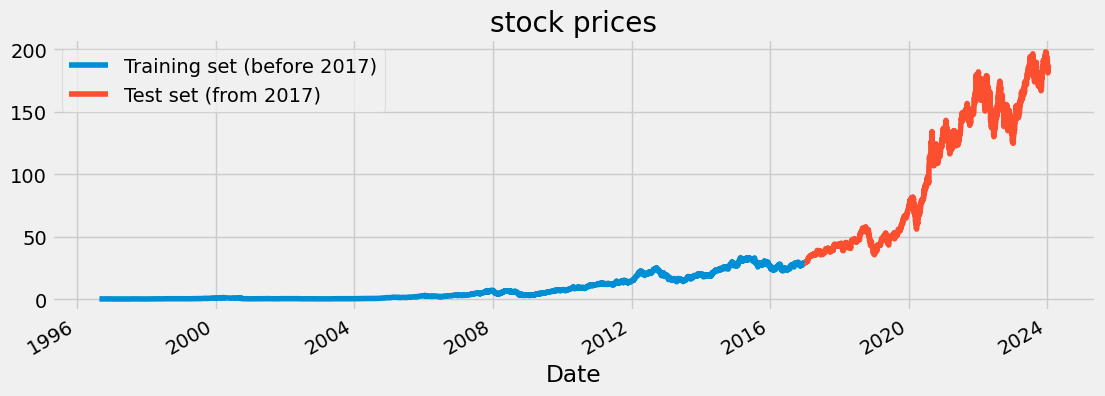

In [61]:
# visualization of "High" attribute of the dataset

df["Close"][:'2016'].plot(figsize=(12,4), legend=True)
df["Close"]["2017":].plot(figsize=(12,4), legend=True)
plt.legend(["Training set (before 2017)", "Test set (from 2017)"])
plt.title("stock prices")
plt.show()

<b><h3> Scaling and Resizing

In [62]:
# scaling the training set

sc = MinMaxScaler(feature_range=(0,1))
train_scaled = sc.fit_transform(train)

In [63]:
#Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements

x_train = []
y_train = []

for i in range(60,2769):
    x_train.append(train_scaled[i-60:i, 0])
    y_train.append(train_scaled[i,0])

x_train, y_train = np.array(x_train), np.array(y_train)
print(len(x_train))
print(len(y_train))

# reshaping x_train for efficient modelling
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

2709
2709


(2709, 60, 1)

<b><h3> LSTM Architecture

In [39]:
# LSTM architecture

regressor = Sequential()
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1))) # add first layer with dropout
regressor.add(Dropout(0.2))
# add second layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# add third layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# add fourth layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units=1)) # the output layer

<b><h3> Compiling

In [40]:
# compiling the LSTM RNN network
regressor.compile(optimizer='rmsprop', loss='mean_squared_error')
# fit to the training set
regressor.fit(x_train, y_train, epochs=5, batch_size=32)

Epoch 1/5
85/85 [==============================] - 18s 118ms/step - loss: 8.5471e-04
Epoch 2/5
85/85 [==============================] - 10s 119ms/step - loss: 2.9259e-04
Epoch 3/5
85/85 [==============================] - 10s 117ms/step - loss: 2.1469e-04
Epoch 4/5
85/85 [==============================] - 9s 103ms/step - loss: 1.9251e-04
Epoch 5/5
85/85 [==============================] - 10s 118ms/step - loss: 1.6622e-04


<b><h3> Saving and loading

In [41]:
regressor.save('Stockprice_LSTM_GRU.h5')
# un comment the line below only if needed and load the drive
#regressor = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/VLG_Stock_price_pred/Stockprice_LSTM_GRU.h5')

In [42]:
dataset_total = pd.concat((df['High'][:'2016'], df['High']['2017':]), axis=0)
print(dataset_total.shape)

inputs = dataset_total[len(dataset_total)-len(test)-60 : ].values
print(inputs.shape)
inputs = inputs.reshape(-1,1)
print(inputs.shape)
inputs = sc.transform(inputs)
print(inputs.shape)

(6892,)
(1829,)
(1829, 1)
(1829, 1)


In [65]:
x_test = []
for i in range(60,1829):
    x_test.append(inputs[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

<b><h3> Visualistion

56/56 [==============================] - 3s 30ms/step


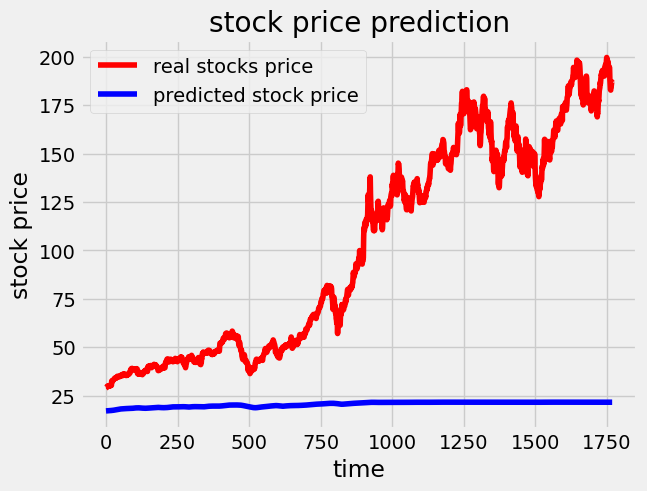

In [44]:
# predicting the stock prices for test set
predicted = regressor.predict(x_test)
predicted = sc.inverse_transform(predicted)
# visualizing the results: predicted vs test
plot_predictions(test, predicted)

The Reason why we have such a poor performance is because we have trained the model on quite an old model and

In [54]:
#The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))

In [64]:
regressorGRU.compile(optimizer=SGD(lr=0.01, momentum=0.9, nesterov=False), loss='mean_squared_error')

# fitting the model

regressorGRU.fit(x_train, y_train, epochs=5, batch_size=150)

Epoch 1/5
19/19 [==============================] - 12s 204ms/step - loss: 8.9843e-04
Epoch 2/5
19/19 [==============================] - 4s 203ms/step - loss: 7.5919e-04
Epoch 3/5
19/19 [==============================] - 5s 278ms/step - loss: 7.2381e-04
Epoch 4/5
19/19 [==============================] - 4s 203ms/step - loss: 7.1264e-04
Epoch 5/5
19/19 [==============================] - 4s 199ms/step - loss: 6.9741e-04


56/56 [==============================] - 6s 55ms/step


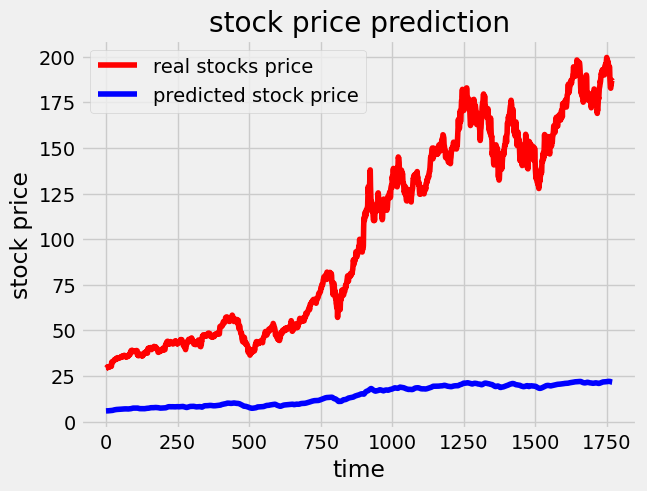

In [66]:
predicted_with_gru = regressorGRU.predict(x_test)
predicted_with_gru = sc.inverse_transform(predicted_with_gru)

plot_predictions(test, predicted_with_gru)

In [67]:
# evaluating the model performance

return_rmse(test, predicted_with_gru)

the root mean squared error is : 99.98159846342296.
